#CSC 369 Final Project

Vehicle Fuel Consumption

In [1]:
## Spark Setup
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u372-ga~us1-0ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.


## Introduction
The goal of this project is to examine the relationship between fuel consumption and various factors such as model year, vehicle class, engine size, and others.


## Dataset

The [dataset](https://www.kaggle.com/datasets/ahmettyilmazz/fuel-consumption) found on Kaggle provides model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada. There are 22556 rows in this dataset.

To help compare vehicles the from different model years, the fuel consumption ratings for 2000 to 2022 vehicles have been adjusted to reflect the improved testing that is more representative of everyday driving. Note that these are approximate values that were generated from the original ratings, not from vehicle testing.

In order to have proper analysis of the data, I had to modify the some columns as text values were being reported differently ("Compact" vs. "COMPACT").

Data Layout:
  * Year
  * Make
  * Model
  * Vehicle Class
  * Engine Size
  * Cylinders
  * Transmission
  * Fuel
  * Fuel Consumption
  * HWY (L/100KM)
  * COMB (L/100KM)
  * COMB (mpg)
  * Emissions

## Questions

- Which model years have the highest fuel efficiency?
  - Is there a linear relationship between year and fuel efficiency?
  - Does newer mean better?

- Which vehicle class has the highest fuel efficiency?

- Is there a relationship between engine size and fuel efficiency? (Does smaller engine mean more efficient...?)

- Is there a relationship between cyclinder count and fuel efficiency? (Does less cylinders mean more efficienct...?)

### Import data into Spark

In [2]:
!wget -q https://raw.githubusercontent.com/nathanip101/csc369-finalproject/master/Fuel_Consumption_2000-2022.csv

#### Import Spark Functions

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql import types as sparktypes
from pyspark.sql.functions import col, lit, avg, count
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

sc = SparkContext()
spark = SparkSession(sc)

#### Set Up DataFrame

In [4]:
df = spark.read.options(header=True).csv("Fuel_Consumption_2000-2022.csv")
df.show()

+----+-----+---------------+-------------+-----------+---------+------------+----+----------------+--------------+---------------+----------+---------+
|YEAR| MAKE|          MODEL|VEHICLE CLASS|ENGINE SIZE|CYLINDERS|TRANSMISSION|FUEL|FUEL CONSUMPTION|HWY (L/100 km)|COMB (L/100 km)|COMB (mpg)|EMISSIONS|
+----+-----+---------------+-------------+-----------+---------+------------+----+----------------+--------------+---------------+----------+---------+
|2000|ACURA|          1.6EL|      COMPACT|        1.6|        4|          A4|   X|             9.2|           6.7|            8.1|        35|      186|
|2000|ACURA|          1.6EL|      COMPACT|        1.6|        4|          M5|   X|             8.5|           6.5|            7.6|        37|      175|
|2000| AUDI|             A4|      COMPACT|        1.8|        4|          A5|   Z|            11.4|           7.2|            9.5|        30|      218|
|2000| AUDI|             A4|      COMPACT|        1.8|        4|          M5|   Z|      

## Which model years have the highest fuel efficiency?

#### First, lets get the average MPG for each model year.

In [5]:
grouped_df = (df
                .groupby('YEAR')
                .agg(avg('COMB (mpg)'))
                .orderBy("avg(COMB (mpg))")
                .withColumnRenamed("avg(COMB (mpg))", "AVG_MPG")
                )
avg_mpg_df = (grouped_df
                  .withColumn('AVG_MPG', (grouped_df['AVG_MPG'] * 10)
                  .cast('integer') / 10)
                  )
avg_mpg_df.show()

+----+-------+
|YEAR|AVG_MPG|
+----+-------+
|2002|   25.8|
|2004|   25.9|
|2007|   26.1|
|2003|   26.1|
|2005|   26.2|
|2006|   26.4|
|2000|   26.4|
|2001|   26.5|
|2008|   26.5|
|2009|   26.6|
|2022|   27.1|
|2021|   27.3|
|2020|   27.4|
|2015|   27.5|
|2019|   27.6|
|2018|   27.6|
|2010|   27.6|
|2017|   27.6|
|2016|   27.7|
|2011|   27.9|
+----+-------+
only showing top 20 rows



#### Now let's perform a linear regression on the data to see if there's a linear relationship between model year and average miles-per-gallon.

In [6]:
df = df.withColumn('YEAR', col('YEAR').cast('integer'))
avg_mpg_df = avg_mpg_df.withColumn('YEAR', col('YEAR').cast('integer'))
df = df.withColumn("COMB (mpg)", col("COMB (mpg)").cast('integer'))

year_assembler1 = VectorAssembler(inputCols=['YEAR'], outputCol='features')
year_assembled_data1 = year_assembler1.transform(df)

year_lr1 = LinearRegression(featuresCol='features', labelCol="COMB (mpg)")
year_lr_model1 = year_lr1.fit(year_assembled_data1)

year_assembler2 = VectorAssembler(inputCols=['YEAR'], outputCol='features')
year_assembled_data2 = year_assembler2.transform(avg_mpg_df)

year_lr2 = LinearRegression(featuresCol='features', labelCol="AVG_MPG")
year_lr_model2 = year_lr2.fit(year_assembled_data2)

print(f"Linear Regression Summary: ")
print(f"MPG Model Coefficient: {year_lr_model1.coefficients}")
print(f"Average MPG Model Coefficient: {year_lr_model2.coefficients}")
print()
print(f"Year to MPG R-squared: {round(year_lr_model1.summary.r2, 2)}")
if year_lr_model1.summary.r2 > 0.5:
  print("The relationship between model year and fuel efficiency is linear.")
else:
  print("The relationship between model year and fuel efficiency is not linear.")
print()
print(f"Year to Average MPG R-squared: {round(year_lr_model2.summary.r2, 2)}")
if year_lr_model2.summary.r2 > 0.5:
  print("The relationship between model year and average fuel efficiency is linear.")
else:
  print("The relationship between model year and average fuel efficiency is not linear.")


Linear Regression Summary: 
MPG Model Coefficient: [0.09368901201148375]
Average MPG Model Coefficient: [0.09328063241146486]

Year to MPG R-squared: 0.01
The relationship between model year and fuel efficiency is not linear.

Year to Average MPG R-squared: 0.28
The relationship between model year and average fuel efficiency is not linear.


## Which vehicle class has the highest fuel efficiency?

In [7]:
grouped_df = (df
                .groupBy("VEHICLE CLASS")
                .agg(avg("COMB (mpg)").alias("AVG_MPG"), count("*").alias("CLASS_COUNT"))
                .orderBy("AVG_MPG", ascending=False)
                )
class_sorted_df = (grouped_df
                  .withColumn('AVG_MPG', (grouped_df['AVG_MPG'] * 10)
                  .cast('integer') / 10)
                  )
class_sorted_df.show(truncate=False)


+------------------------+-------+-----------+
|VEHICLE CLASS           |AVG_MPG|CLASS_COUNT|
+------------------------+-------+-----------+
|STATION WAGON - SMALL   |33.2   |877        |
|COMPACT                 |32.2   |3127       |
|MID-SIZE                |30.7   |2960       |
|SUBCOMPACT              |29.3   |2010       |
|SUV - SMALL             |29.0   |1756       |
|MINICOMPACT             |28.7   |994        |
|STATION WAGON - MID-SIZE|28.7   |387        |
|SPECIAL PURPOSE VEHICLE |27.3   |114        |
|TWO-SEATER              |26.0   |1312       |
|FULL-SIZE               |25.9   |1503       |
|MINIVAN                 |25.2   |408        |
|PICKUP TRUCK - SMALL    |25.0   |511        |
|SUV                     |24.5   |2640       |
|SUV - STANDARD          |22.0   |1122       |
|PICKUP TRUCK - STANDARD |21.0   |2204       |
|VAN - CARGO             |18.5   |332        |
|VAN - PASSENGER         |17.0   |299        |
+------------------------+-------+-----------+



Surprisingly, small station wagons beat out compact cars as the vehicle  class with the lowest MPG. That was not something I expected.

## Is there a relationship between engine size and fuel efficiency?


In [8]:
df = df.withColumn('ENGINE SIZE', col('ENGINE SIZE').cast('integer'))

assembler = VectorAssembler(inputCols=["ENGINE SIZE"], outputCol="features")
df_with_features = assembler.transform(df)

lr = LinearRegression(featuresCol="features", labelCol="COMB (mpg)")
engine_size_lr_model = lr.fit(df_with_features)

print("Linear Regression Coefficients: ", engine_size_lr_model.coefficients)
engine_size_coefficient = engine_size_lr_model.coefficients[0]
if engine_size_coefficient < 0:
    print("Smaller engine size results in higher fuel efficiency.")
elif engine_size_coefficient > 0:
    print("Smaller engine size results in lower fuel efficiency.")
else:
    print("Engine size doesn't have a significant impact on fuel efficiency.")

print()

print(f"R-squared: {round(engine_size_lr_model.summary.r2, 2)}")
if engine_size_lr_model.summary.r2 > 0.5:
  print("The relationship between engine size and fuel efficiency is linear.")
else:
  print("The relationship between engine size and fuel efficiency is not linear.")

Linear Regression Coefficients:  [-4.1300417066875195]
Smaller engine size results in higher fuel efficiency.

R-squared: 0.57
The relationship between engine size and fuel efficiency is linear.


## Is there a relationship between cyclinder count and fuel efficiency?

In [9]:
df = df.withColumn('CYLINDERS', col('CYLINDERS').cast('integer'))

assembler = VectorAssembler(inputCols=["CYLINDERS"], outputCol="features")
df_with_features = assembler.transform(df)

lr = LinearRegression(featuresCol="features", labelCol="COMB (mpg)")
cylinder_count_lr_model = lr.fit(df_with_features)

print("Linear Regression Coefficients: ", cylinder_count_lr_model.coefficients)
engine_size_coefficient = cylinder_count_lr_model.coefficients[0]
cylinder_count_coefficient = cylinder_count_lr_model.coefficients[0]
if cylinder_count_coefficient < 0:
    print("Lower cylinder count results in higher fuel efficiency.")
elif cylinder_count_coefficient > 0:
    print("Lower cylinder count results in lower fuel efficiency.")
else:
    print("Cylinder count doesn't have a significant impact on fuel efficiency.")

print()

print(f"R-squared: {round(cylinder_count_lr_model.summary.r2, 2)}")
if cylinder_count_lr_model.summary.r2 > 0.5:
  print("The relationship between cylinder count and fuel efficiency is linear.")
else:
  print("The relationship between cylinder count and fuel efficiency is not linear.")


Linear Regression Coefficients:  [-2.8955572544468278]
Lower cylinder count results in higher fuel efficiency.

R-squared: 0.51
The relationship between cylinder count and fuel efficiency is linear.


## Results

### Which model years have the highest fuel efficiency?

Linear Regression Summary: 
MPG Model Coefficient: [0.09368901201148375]
Average MPG Model Coefficient: [0.09328063241146486]

Year to MPG R-squared: 0.01
The relationship between cylinder count and fuel efficiency is not linear.

Year to Average MPG R-squared: 0.28
The relationship between cylinder count and fuel efficiency is not linear.


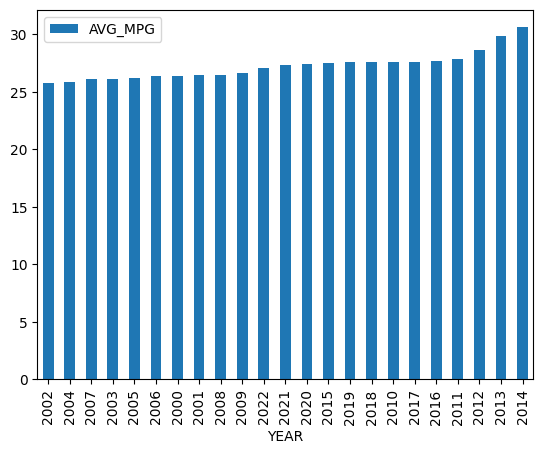

In [10]:
avg_mpg_df.toPandas().plot(x="YEAR", y="AVG_MPG", kind="bar")

print(f"Linear Regression Summary: ")
print(f"MPG Model Coefficient: {year_lr_model1.coefficients}")
print(f"Average MPG Model Coefficient: {year_lr_model2.coefficients}")
print()
print(f"Year to MPG R-squared: {round(year_lr_model1.summary.r2, 2)}")
if year_lr_model1.summary.r2 > 0.5:
  print("The relationship between cylinder count and fuel efficiency is linear.")
else:
  print("The relationship between cylinder count and fuel efficiency is not linear.")
print()
print(f"Year to Average MPG R-squared: {round(year_lr_model2.summary.r2, 2)}")
if year_lr_model2.summary.r2 > 0.5:
  print("The relationship between cylinder count and fuel efficiency is linear.")
else:
  print("The relationship between cylinder count and fuel efficiency is not linear.")


As seen in the above, there doesn't seem like there is a correlation between the year and the efficiency of the vehicle. This is also supported by our linear regression model.

In order to find the relationship between model years and miles-per-gallon numbers, we made two linear regression models, one with the model year and MPG, and the second with where we grouped together all vehicles within each model year and averaged their MPG.

An acceptable R-squared value that can be considered a linear relationship falls between 0.50 and 0.99. As shown, the R-squared values are 0.01 and 0.28, both of which are far from the optimal range. Therefore, it can be concluded that there is no linear relationship between model year and miles-per-gallon. In addition to that, just looking at the data, cars from 2011 had a higher MPG than the ones made in 2022. That being said, if we look at the coefficients of both models, they are positive, signifying that it can be said that, the newer the car, the better the MPG; it just can't be concluded that a newer car is guaranteed a better MPG.

I had thought that, as newer vehicles and newer technologies were developed, fuel efficiency would improve. However, per this dataset, that is not the case. That could be because of many factors. Maybe I can examine those in the future

### Which vehicle class has the highest fuel efficiency?

<Axes: xlabel='VEHICLE CLASS'>

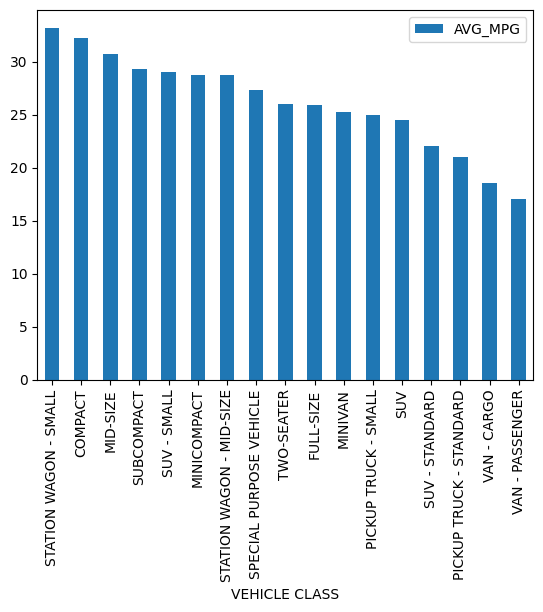

In [11]:
class_sorted_df.toPandas().plot(x="VEHICLE CLASS", y="AVG_MPG", kind="bar")

### Is there a relationship between engine size and fuel efficiency?

In [12]:
print("Linear Regression Coefficients: ", engine_size_lr_model.coefficients)
engine_size_coefficient = engine_size_lr_model.coefficients[0]
if engine_size_coefficient < 0:
    print("Smaller engine size results in higher fuel efficiency.")
elif engine_size_coefficient > 0:
    print("Smaller engine size results in lower fuel efficiency.")
else:
    print("Engine size doesn't have a significant impact on fuel efficiency.")

print()

print(f"R-squared: {round(engine_size_lr_model.summary.r2, 2)}")
if engine_size_lr_model.summary.r2 > 0.5:
  print("The relationship between engine size and fuel efficiency is linear.")
else:
  print("The relationship between engine size and fuel efficiency is not linear.")

Linear Regression Coefficients:  [-4.1300417066875195]
Smaller engine size results in higher fuel efficiency.

R-squared: 0.57
The relationship between engine size and fuel efficiency is linear.


From this we can conclude that yes, there is a relationship between engine size and fuel efficiency, and it is a linear relationship. We also now know that a smaller egnine results in a higher average miles per gallon.

### Is there a relationship between cyclinder count and fuel efficiency?

In [13]:
print("Linear Regression Coefficients: ", cylinder_count_lr_model.coefficients)
engine_size_coefficient = cylinder_count_lr_model.coefficients[0]
cylinder_count_coefficient = cylinder_count_lr_model.coefficients[0]
if cylinder_count_coefficient < 0:
    print("Lower cylinder count results in higher fuel efficiency.")
elif cylinder_count_coefficient > 0:
    print("Lower cylinder count results in lower fuel efficiency.")
else:
    print("Cylinder count doesn't have a significant impact on fuel efficiency.")

print()

print(f"R-squared: {round(cylinder_count_lr_model.summary.r2, 2)}")
if cylinder_count_lr_model.summary.r2 > 0.5:
  print("The relationship between cylinder count and fuel efficiency is linear.")
else:
  print("The relationship between cylinder count and fuel efficiency is not linear.")


Linear Regression Coefficients:  [-2.8955572544468278]
Lower cylinder count results in higher fuel efficiency.

R-squared: 0.51
The relationship between cylinder count and fuel efficiency is linear.


From this we can conclude that yes, there is a relationship between cyclinder count and fuel efficiency, and it is a linear relationship. Less cylinders results in a higher miles per gallon.

## Conclusion

It was interesting working with this dataset. There were some things I expected, such as the effects of engine size and cylinder count on miles per gallon. However, I was expecting a greater correlation between the year a vehicle was manufactured and its fuel efficiency.

Overall, I liked using PySpark to handle this data. I have used Pandas before to handle similar datasets and PySpark was just as easy to use. PySpark is a great tool to use to interface data and I will consider it in my future projects!